In [1]:
%matplotlib inline

# Intro to Keras

**Course**: CMSC 389A Practical Deep Learning  
**Author**: Sujith Vishwajith

**Task**:
We want to build a neural network using Keras that is able to classify if a person has diabetes or not based on a fixed set of features:
1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years)  

The goal of this tutorial is to help you understand how to use Keras.

**Packages**  
Lets import the following required packages.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import shuffle

# Fixed seed for reproducibility
kSEED = 5
np.random.seed(kSEED)

/home/justin/.virtualenvs/cmsc389a/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data

We'll be using the Pima Indians Diabetes dataset provided by UCI [here](http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/) to train our model.

**Reading the Data**  
Let's first load and read the dataset into our program.

In [3]:
file_name = 'diabetes.csv'
columns = [
    'Number of times pregnant',
    'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
    'Diastolic blood pressure (mm Hg)',
    'Triceps skin fold thickness (mm)',
    '2-Hour serum insulin (mu U/ml)',
    'Body mass index (weight in kg/(height in m)^2)',
    'Diabetes pedigree function',
    'Age (years)',
    'Class variable (0: no diabetes, 1: diabetes)']

df = pd.read_csv(file_name, names=columns, delimiter=',', header=-1)
df[columns[:-1]] = df[columns[:-1]].astype(float)
df[columns[-1]] = df[columns[-1]].astype(int)

Lets take a peek at the data

In [4]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),"Class variable (0: no diabetes, 1: diabetes)"
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


An important part of handling data for training neural networks is to normalize all the values between -1 and 1. Remember that this only applied to continous values not one hot class encodings (e.g. Male -> 0, Female -> 1).

In [5]:
# Normalize all the values between -1 and 1 as discussed in class
for feature in df.columns[:-1]:
    max_value = df[feature].max()
    min_value = df[feature].min()
    mean_value = df[feature].mean()
    df[feature] = (df[feature] - mean_value) / (max_value - min_value)

Lets now examine the data after normalizing it.

In [6]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),"Class variable (0: no diabetes, 1: diabetes)"
0,0.126762,0.136208,0.023726,0.146096,-0.094326,0.023956,0.066236,0.279319,1
1,-0.167356,-0.180375,-0.025455,0.085490,-0.094326,-0.080366,-0.051612,-0.037348,0
2,0.244409,0.312088,-0.041848,-0.207439,-0.094326,-0.129547,0.085450,-0.020681,1
3,-0.167356,-0.160274,-0.025455,0.024884,0.016785,-0.058012,-0.130178,-0.204015,0
4,-0.226180,0.080932,-0.238569,0.146096,0.104256,0.165535,0.775458,-0.004015,1


## Train-test Split

Training our model on the entire dataset then testing on a subset of it is unfair as the model has seen the examples before. To ensure fairness, a common practice is to train the models on a portion of the data and then test its performance on the rest. In our case, we will take a random 80% for training examples and a random 20% for testing.

The class example will be used to represent our data examples.

In [7]:
class Example:
    """
    Class to represent a data example.
    """

    def __init__(self, features, label):
        """
        Create a new example.

        :param features: The real valued features of patient (list)
        :param label: The label (0 / 1) of the example
        """
        self.features = features
        self.label = label

The list `data` contains all our examples in the dataset.

In [8]:
data = []
for row in df.itertuples():
    label = row[9]
    features = row[1:9]
    example = Example(features, label)
    data.append(example)

Performing a train-test split on the data after randomly shuffling it. Make sure you **ALWAYS** shuffle your training data.

- `X_train`: contains the features we train on
- `y_train`: contains the label for each index in `X_train` 
- `X_test` and `y_test` follow the same idea but for testing data

In [32]:
# Amount of data used for training
frac = 0.8

data = shuffle(data, random_state=kSEED)
split_index = int(frac * len(data))
train = data[:split_index]
test = data[split_index:]

X_train = np.array([example.features for example in train])
y_train = [example.label for example in train]
X_test = np.array([example.features for example in test])
y_test = [example.label for example in test]

print('Total Examples: {:}\nTrain Examples: {:}\nTest Examples: {:}'.format(len(data), len(X_train), len(X_test)))

Total Examples: 768
Train Examples: 614
Test Examples: 154


## Implementing the Model

In this section we get our hands dirty and actually build the model. Our model will have the following architecture:

- Fully connected feed-forward network with 3 layers
- 8 input neurons (1 for each feature)
- 12 neurons in hidden layer 1; Activation: ReLU
- 8 neurons in hidden layer 2; Activation: ReLU
- 1 output neuron containing predictionl; Activation: Sigmoid

### Setting up the Layers

We use the Sequential() class because Keras models are defined as a 'sequence' of layers. The input dimension argument in the first layer corresponds the number of input features the layer will recieve.

The Dense class specifies a fully connected layer meaning that every single neuron in the layer is connected to the next and previous layers' neurons. The network is initialized with small random weights following either a uniform or normal distribution (you can specify). 

The first two layers will use the ReLU activation function (as discussed in class we see that in modern networks it performs better). And for the last layer, we will use the sigmoid function to output a probability of confidence.

Why did we decide this structure? We picked a network architecture that we think is big enough to capture and learn the structure of our input. For larger datasets with more features, you would need a larger network. There is now way to compute the optimal network layout just by the data. It's important to experiment with different network architectures and select the best one.

In [10]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compiling the Model

An important step is to compile the model after setting its architecture. This calls our backend (in this case Tensorflow) to setup a representation of the network which we can train based on your system. Since this is a binary classification (only 2 classes), we will use the binary crossentropy loss function. Don't worry if you don't understand this as we will talk about it in class. Check out the link [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) for more information on loss functions. The optimizer we will use is the Adam optimizer (also will discuss in class) and our metric for training which we want to see will be accuracy.


#### Definition of cross entropy loss:
Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the Model

Now is one of the most important steps in building a neural network. We will train then neural network on the data we setup before. Notice how we only train the network on 80% of the data. An epoch refers to training over the entire data set 1 times. We will train for 20 epochs meaning we will go over the dataset 20 times. We will be using SGD so we can specify a batch size of 10 meaning our model will train on 10 examples at each step rather than the entire dataset (which we saw was computationally infeasible).

In [28]:
model.fit(X_train, y_train, epochs=20, batch_size=10)

Epoch 1/20
614/614 [==============================] - 0s 290us/step - loss: 0.6794 - acc: 0.6254
Epoch 2/20
614/614 [==============================] - 0s 136us/step - loss: 0.6574 - acc: 0.6401
Epoch 3/20
614/614 [==============================] - 0s 121us/step - loss: 0.6329 - acc: 0.6401
Epoch 4/20
614/614 [==============================] - 0s 129us/step - loss: 0.6046 - acc: 0.6450
Epoch 5/20
614/614 [==============================] - 0s 133us/step - loss: 0.5774 - acc: 0.6710
Epoch 6/20
614/614 [==============================] - 0s 129us/step - loss: 0.5535 - acc: 0.7020
Epoch 7/20
614/614 [==============================] - 0s 129us/step - loss: 0.5330 - acc: 0.7296
Epoch 8/20
614/614 [==============================] - 0s 121us/step - loss: 0.5173 - acc: 0.7394
Epoch 9/20
614/614 [==============================] - 0s 137us/step - loss: 0.5068 - acc: 0.7508
Epoch 10/20
614/614 [==============================] - 0s 132us/step - loss: 0.4977 - acc: 0.7476
Epoch 11/20
614/614 [========

### Testing the Model

We want to know see how our model performs on our testing dataset which we left aside. We can use the `evaluate()` function on our model to pass in our testing features with their corresponding labels. We can then access the accracy and print it out.

In [33]:
scores = model.evaluate(X_test, y_test, verbose=False)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 75.32%


### Results

We can see that using an incredibly small 3 layer neural network was able an accuracy of `77.3%` after only 20 epochs. This is equal if not better performance than our logistic regression model. The best part is neural networks learn with more data so we can see large improvements in performance with larger datasets.

## Visualizing the Training

We can also visualize the loss function and validation set accuracy over time.

The validation set is used to monitor the neural networks training performance over time. If the validation accuracy stops increasing or the loss stops decreasing, it can signify a problem or that the neural network is at its best performance with the data. Its important to note that the neural network never trains on the validation set, it just uses it as a baseline while training. Notice how accuracy on the training set is always going to be higher than the validation or test set. 

###### Code from [here](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/).

In [43]:
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


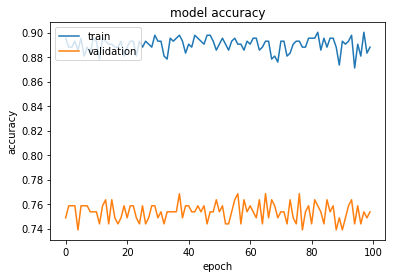

In [44]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

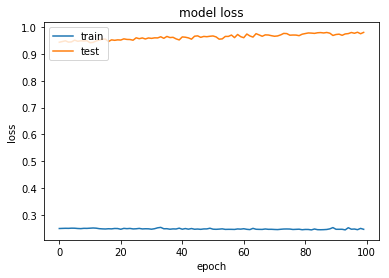

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()